<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/dogs_and_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct 14 22:15:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import urllib.request
import os
import zipfile
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [3]:
DOWNLOAD_DIR = "/tmp/"
CAT_SOURCE_DIR = f"{DOWNLOAD_DIR}PetImages/Cat/"
DOG_SOURCE_DIR = f"{DOWNLOAD_DIR}PetImages/Dog/"
CAT_V_DOGS_DIR = f"{DOWNLOAD_DIR}cats-v-dogs/"
TRAINING_DIR = f"{CAT_V_DOGS_DIR}/training/"
TESTING_DIR = f"{CAT_V_DOGS_DIR}/testing/"
TRAINING_CATS_DIR = f"{TRAINING_DIR}cats/"
TESTING_CATS_DIR = f"{TESTING_DIR}cats/"
TRAINING_DOGS_DIR = f"{TRAINING_DIR}dogs/"
TESTING_DOGS_DIR = f"{TESTING_DIR}dogs/"

In [4]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"

urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(DOWNLOAD_DIR)
#zip_ref.extractall()
zip_ref.close()

In [5]:
print(f'Cat samples: {len(os.listdir(CAT_SOURCE_DIR))}')
print(f'Dog samples: {len(os.listdir(DOG_SOURCE_DIR))}')

Cat samples: 12501
Dog samples: 12501


In [6]:
try:
  os.mkdir(CAT_V_DOGS_DIR)
  os.mkdir(TRAINING_DIR)
  os.mkdir(TESTING_DIR)
  os.mkdir(TRAINING_CATS_DIR)
  os.mkdir(TESTING_CATS_DIR)
  os.mkdir(TRAINING_DOGS_DIR)
  os.mkdir(TESTING_DOGS_DIR)
except OSError:
  pass

In [8]:
def split_data(source, training, testing, split_size):
  files = []
  for filename in os.listdir(source):
    file = f'{source}{filename}'
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(f'{filename} is zero length, so ignoring.')

  training_length = int(len(files) * split_size)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[:testing_length]

  for filename in training_set:
    this_file = source + filename
    destination = training + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = source + filename
    destination = testing + filename
    copyfile(this_file, destination)



split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [9]:
try:
  print(f'Split training cats samples: {len(os.listdir(TRAINING_CATS_DIR))}')
  print(f'Split training dogs samples: {len(os.listdir(TESTING_CATS_DIR))}')
  print(f'Split testing cats samples: {len(os.listdir(TRAINING_DOGS_DIR))}')
  print(f'Split testing dogs samples: {len(os.listdir(TESTING_DOGS_DIR))}')
except OSError:
  print('Target split folders are empty.')

Split training cats samples: 12370
Split training dogs samples: 2369
Split testing cats samples: 12370
Split testing dogs samples: 2360


In [11]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=100,
    class_mode='binary',
    target_size=(150, 150)
)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    TESTING_DIR,
    batch_size=100,
    class_mode='binary',
    target_size=(150, 150)
)

Found 24738 images belonging to 2 classes.
Found 4729 images belonging to 2 classes.


In [12]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pre_trained_model = InceptionV3(
  input_shape=(150, 150, 3),
  include_top=False,
  weights=None
)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print(f'last layer output shape: {last_layer.output_shape}')
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [13]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='sigmoid')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(
    optimizer=RMSprop(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
204/248 [=======================>......] - ETA: 30s - loss: 0.2205 - acc: 0.9082

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

248/248 [==============================] - 191s 769ms/step - loss: 0.2095 - acc: 0.9133 - val_loss: 0.0710 - val_acc: 0.9723
Epoch 2/20
248/248 [==============================] - 186s 748ms/step - loss: 0.1508 - acc: 0.9382 - val_loss: 0.0650 - val_acc: 0.9734
Epoch 3/20
248/248 [==============================] - 185s 746ms/step - loss: 0.1351 - acc: 0.9433 - val_loss: 0.0747 - val_acc: 0.9721
Epoch 4/20
248/248 [==============================] - 186s 752ms/step - loss: 0.1269 - acc: 0.9473 - val_loss: 0.0622 - val_acc: 0.9772
Epoch 5/20
248/248 [==============================] - 192s 775ms/step - loss: 0.1249 - acc: 0.9466 - val_loss: 0.0593 - val_acc: 0.9757
Epoch 6/20
248/248 [==============================] - 190s 767ms/step - loss: 0.1234 - acc: 0.9500 - val_loss: 0.0560 - val_acc: 0.9759
Epoch 7/20
248/248 [==============================] - 186s 750ms/step - loss: 0.1175 - acc: 0.9500 - val_loss: 0.0521 - val_acc: 0.9791
Epoch 8/20
248/248 [==============================] - 192s 

<Figure size 432x288 with 0 Axes>

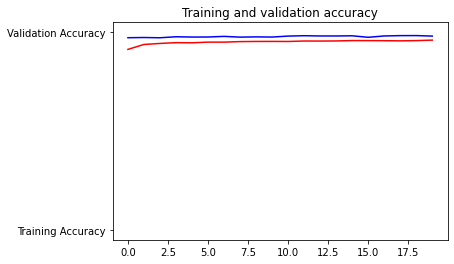

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()


In [23]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = f"/content/{fn}"
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0] > 0.5:
    print(f"{fn} is a dog")
  else:
    print(f"{fn} is a cat")

Saving cat150150.png to cat150150.png
[[0.9747242]]
[0.9747242]
cat150150.png is a dog
